In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Data
df = pd.read_parquet('final_dataset_enhanced.parquet', engine='fastparquet')

# 2. Temporal Sort and Split
# We must perform the analysis only on the Training set to avoid data leakage.
if 'issue_d' in df.columns:
    df['issue_d'] = pd.to_datetime(df['issue_d'])
    df = df.sort_values('issue_d')
    # Drop date column for correlation analysis but keep the order
    df_model = df.drop(columns=['issue_d'])
else:
    df_model = df.copy()

# Split at 80% (Chronological split)
split_idx = int(len(df_model) * 0.80)

# Keep only the Training Set for analysis
df_train = df_model.iloc[:split_idx]

print(f"Analysis performed on Train Set with shape: {df_train.shape}")

Analysis performed on Train Set with shape: (1045109, 150)


In [3]:
# 3. Compute Global Correlation Matrix
# Filter to keep only numeric columns
df_numeric = df_train.select_dtypes(include=['number'])

print("Calculating correlation matrix... ")
corr_matrix = df_numeric.corr()

print("Matrix calculated.")

Calculating correlation matrix... 
Matrix calculated.


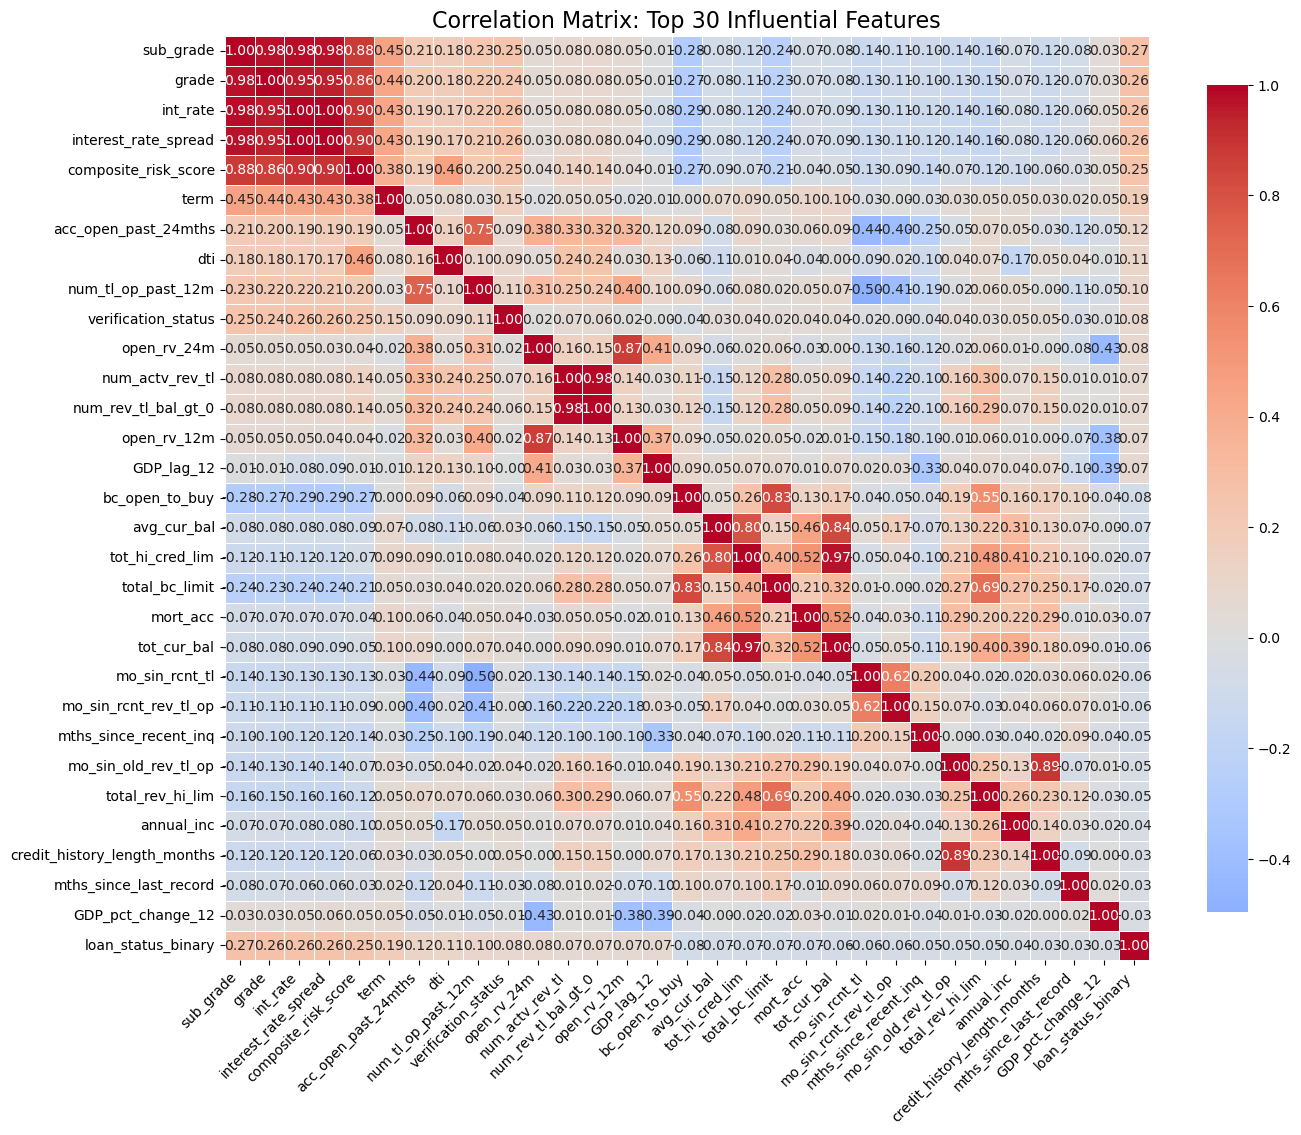

In [5]:
# 4. Zoom on Target Correlations 
target_col = 'loan_status_binary'

# Safety Check: Ensure the target is actually in the numeric dataframe
if target_col not in df_numeric.columns:
    # If missing, add it back from original training data
    df_numeric[target_col] = df_train[target_col].astype(int)

# Calculate correlations specifically against the target
all_correlations = corr_matrix[target_col].drop(target_col)

# Get top 15 positive correlations (Risk Factors)
top_pos = all_correlations.nlargest(15)
# Get top 15 negative correlations (Protective Factors)
top_neg = all_correlations.nsmallest(15)

# Combine indices to select columns
cols_to_plot = top_pos.index.tolist() + top_neg.index.tolist()
# Add the target back to the list so it appears in the plot
cols_to_plot.append(target_col)

# Compute a smaller correlation matrix for just these features
corr_zoom = df_numeric[cols_to_plot].corr()

# Display Square Heatmap
plt.figure(figsize=(14, 12)) 
sns.heatmap(
    corr_zoom,
    annot=True,       
    fmt=".2f",         
    cmap='coolwarm',  
    center=0,
    linewidths=0.5,
    square=True,       
    cbar_kws={"shrink": .8}
)

plt.title("Correlation Matrix: Top 30 Influential Features", fontsize=16)
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [6]:
# 5. Identifying Multicollinearity (Redundant Features)
# This step justifies why we will drop highly correlated features in the Feature Engineering notebook.

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find pairs with correlation > 0.95
high_corr_pairs = []
for column in upper.columns:
    for row in upper.index:
        val = upper.loc[row, column]
        # Skip diagonal (always 1)
        if row != column and abs(val) > 0.95:
            high_corr_pairs.append((row, column, val))

# Display results
print(f"Number of highly correlated pairs (> 0.95): {len(high_corr_pairs)}\n")
print(f"{'Feature 1':<30} | {'Feature 2':<30} | {'Correlation'}")
print("-" * 75)

# Show first 20 pairs
for v1, v2, val in high_corr_pairs[:20]:
    print(f"{v1:<30} | {v2:<30} | {val:.4f}")

Number of highly correlated pairs (> 0.95): 127

Feature 1                      | Feature 2                      | Correlation
---------------------------------------------------------------------------
loan_amnt                      | installment                    | 0.9533
int_rate                       | grade                          | 0.9550
int_rate                       | sub_grade                      | 0.9783
grade                          | sub_grade                      | 0.9762
num_actv_rev_tl                | num_rev_tl_bal_gt_0            | 0.9835
open_acc                       | num_sats                       | 0.9773
tot_cur_bal                    | tot_hi_cred_lim                | 0.9738
CPI                            | CPI_lag_1                      | 0.9921
CPI                            | CPI_lag_3                      | 0.9655
CPI_lag_1                      | CPI_lag_3                      | 0.9794
CPI_lag_3                      | CPI_lag_6                      | 0

Found 62 economic features.


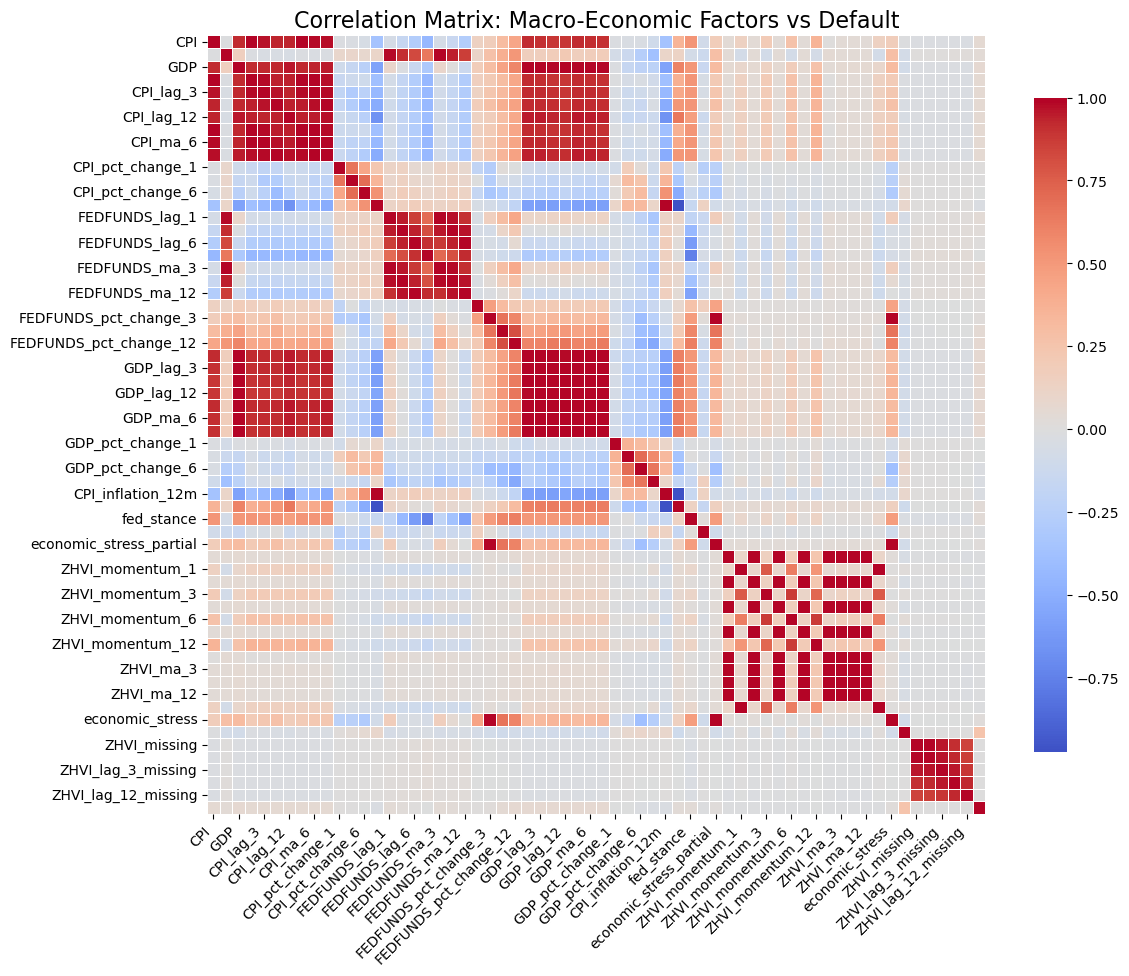

In [9]:
# 6. Economic Indicators Analysis
eco_keywords = ['gdp', 'unemploy', 'cpi', 'interest', 'zhvi', 'fed', 'inflation', 'real_interest', 'economic']
eco_cols = [col for col in df_numeric.columns if any(keyword in col.lower() for keyword in eco_keywords)]

target_col = 'loan_status_binary'
if target_col not in eco_cols and target_col in df_numeric.columns:
    eco_cols.append(target_col)

if len(eco_cols) > 1:
    print(f"Found {len(eco_cols)} economic features.")
    
    eco_corr = df_numeric[eco_cols].corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        eco_corr,
        annot=False,       
        cmap='coolwarm', 
        center=0, 
        linewidths=0.5,
        square=True,
        cbar_kws={"shrink": .8}
    )
    plt.title("Correlation Matrix: Macro-Economic Factors vs Default", fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("No economic features found.")